In [1]:
import pandas as pd
import numpy as np
import pandas_profiling # https://github.com/pandas-profiling/pandas-profiling
import seaborn as sns
import matplotlib.pyplot as plt
import qgrid
from numpy import exp, array, random, dot
import numpy.random as r
from scipy import stats
from scipy.stats import skew, norm
from scipy.stats.stats import pearsonr
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.preprocessing import OrdinalEncoder, LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error, mean_squared_log_error, accuracy_score
import time

np.random.seed(1)
sns.set_style("dark")
# plt.rcParams['figure.figsize'] = 12, 8

## Load data

The data files train.csv and test.csv contain gray-scale images of hand-drawn digits, from zero through nine.

The training data set, (train.csv), has 785 columns. The first column, called "label", is the digit that was drawn by the user. The rest of the columns contain the pixel-values of the associated image. Each image is 28 pixels in height and 28 pixels in width, for a total of 784 pixels in total. Each pixel has a single pixel-value associated with it, indicating the lightness or darkness of that pixel, with higher numbers meaning darker. This pixel-value is an integer between 0 and 255, inclusive.

Each pixel column in the training set has a name like pixelx, where x is an integer between 0 and 783, inclusive. To locate this pixel on the image, suppose that we have decomposed x as x = i * 28 + j, where i and j are integers between 0 and 27, inclusive. Then pixelx is located on row i and column j of a 28 x 28 matrix, (indexing by zero).


In [2]:
train = pd.read_csv('../data/digit-recognizer/train.csv')
test = pd.read_csv('../data/digit-recognizer/test.csv')
print(f"Size of train dataset: {train.shape}")
print(f"Size of test dataset: {test.shape}")

Size of train dataset: (42000, 785)
Size of test dataset: (28000, 784)


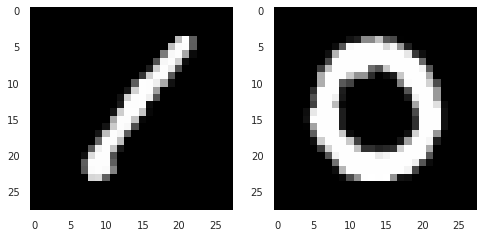

In [3]:
plt.subplot(121)
plt.imshow(np.array(train.iloc[0, 1:]).reshape(28,28), cmap=plt.get_cmap('gray'))
plt.subplot(122)
plt.imshow(np.array(train.iloc[1, 1:]).reshape(28,28), cmap=plt.get_cmap('gray'))
plt.show()

## Preprocess data

Data preprocessing would include:
* Standardization (numeric values are rescaled in order to have mean=0 and standard deviation=1)
* Split the dataset on train and test datasets

In [4]:
def vectorize_y(y):
    y_vect = np.zeros((len(y), 10))
    y_vect[list(range(len(y))), y] = 1
    return y_vect


In [5]:
X = train.iloc[:, 1:]/255
y = train.iloc[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
y_v_train = vectorize_y(y_train)
# y_v_test = vectorize_y(y_test)

# or use a subset for quick run
train_size = 100
test_size = int(train_size*0.2)
X_train = X_train.iloc[:train_size, :]
y_v_train = y_v_train[:train_size, :]
X_test = X_test.iloc[:test_size, :]
y_test = y_test[:test_size]

# X_train = X_train.head()
# y_v_train = y_v_train[:5, :]
# X_test = X_train.head()
# y_v_test = y_test.head()

## Build a model


THE LEARNING ALGORITHM
1. Initialize weights and biases randomly
2. Iterate over the data<br>
    i. Compute the output of neural network using sigmoid function<br>
    ii. Compute the loss using the square error loss function<br>
    iii. W(new) = W(old) — α ∆W<br>
    iv. B(new) = B(old) — α ∆B<br>
3. Repeat in order to get minimal error

In [38]:
class DigitRecognitionNN():
    def __init__(self, structure, epochs=3, learninig_rate=0.01):
        self.structure = structure
        self.epochs = epochs
        self.learninig_rate = learninig_rate
        self.params = self.initialize()
        
    def initialize(self):
        params = {}
        for i in range(1, len(self.structure)):
            params[f'W{i}'] = np.random.randn(self.structure[i], self.structure[i-1]) * np.sqrt(1./self.structure[i])
#             params[f'b{i}'] = np.random.randn(self.structure[i]) * np.sqrt(1./self.structure[i]) # r.random_sample((self.structure[i-1], 1)) 
#             print("Initialized {} layer: weights {}, biases {}".format(i, params[f'W{i}'].shape, params[f'b{i}'].shape)) 
        return params
    
    def sigmoid(self, x, derivative=False):
        if derivative:
            return x * (1 - x)
        return 1/(1 + np.exp(-x))

    def forward_pass(self, x_train):
        self.params['A0'] = x_train
        for i in range(1, len(self.structure)):
            self.params[f'Z{i}'] = np.dot(self.params[f'W{i}'], self.params[f'A{i-1}'])
#             self.params[f'Z{i}'] += self.params[f'b{i}']
            self.params[f'A{i}'] = self.sigmoid(self.params[f'Z{i}'])
        return self.params[f'A{len(self.structure)-1}']
    
    def backward_pass(self, y_train, output):
        gradients = {}
        error = y_train - output
        last_gradient_index = len(self.structure)-1
        gradients[f'W{last_gradient_index}'] = np.dot(error, self.params[f'A{last_gradient_index}'])
#         gradients[f'b{last_gradient_index}'] = np.sum(error)#, axis=1, keepdims=True)
        for i in range(len(self.structure)-2, 0, -1):
            a = np.dot(error, self.params[f'W{i+1}']).T
            error = np.multiply(a, self.sigmoid(self.params[f'Z{i}'], derivative=True))
            gradients[f'W{i}'] = np.dot(error, self.params[f'A{i}'].T)
#             gradients[f'b{i}'] = np.sum(error)#, axis=1, keepdims=True)
        return gradients
    
    def update_weights(self, gradients):
        for key, value in self.params.items():
            if 'W' in key or 'b' in key:
                self.params[key] -= self.learninig_rate * gradients[key]
                
    def compute_accuracy(self, X, Y):
        predictions = []
        for x, y in zip(X, Y):
            output = self.forward_pass(x)
            pred = np.argmax(output)
            predictions.append(pred == y)
        summed = sum(predictions) / 100.0
        return np.average(summed)

    def train(self, x_train, y_train, x_val, y_val):
        start_time = time.time()
        print(f'Starting to train neural networks with {self.epochs} epochs.')
        for epoch in range(self.epochs):
            print(f'Iteration {epoch} of {self.epochs}.')
            for x, y in zip(x_train.values, y_train):
                #feed forward
                output = self.forward_pass(x)
                # backpropagation
                gradients = self.backward_pass(y, output)
                # update weights and biases
                self.update_weights(gradients)
            train_accuracy = self.compute_accuracy(x_train.values, np.argmax(y_train, axis=1))
            test_accuracy = self.compute_accuracy(x_val.values, y_val)
            print('Epoch: {0}, Time Spent: {1:.2f}s'.format(epoch+1, time.time() - start_time))
            print(f"\tAccuracy on train set: {train_accuracy}.\n\tAccuracy on test set: {test_accuracy}.")
        print("Finished.")


In [39]:
nn_structure = [784, 350, 10]
drnn = DigitRecognitionNN(nn_structure, epochs=3, learninig_rate=0.01)
drnn.train(X_train, y_v_train, X_test, y_test)

Starting to train neural networks with 3 epochs.
Iteration 0 of 3.
output [8.96517286e-01 1.18772993e-03 9.76434270e-01 1.85716347e-01
 2.93808932e-04 1.56224855e-02 6.87392608e-02 7.45438496e-02
 3.07133620e-01 7.71390208e-01]
y [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
gradie -2.4903713035863695
output [0.63792657 0.45431887 0.7367222  0.56883327 0.38625219 0.4964565
 0.48665565 0.60100092 0.63710507 0.76941258]
y [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
gradie -2.9024477985092436
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
gradie -2.0000000000004508
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
gradie -2.0000000099456168
output [0.50000002 0.50000001 0.50000002 0.50000001 0.50000001 0.50000001
 0.50000001 0.50000001 0.50000002 0.50000002]
y [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
gradie -2.0000001205977105
output [0.50013879 0.50009739 0.50017628 0.50012131 0.5000818  0.50010602
 0.50009712 0.50012805 0.50011925 0.50016127]
y [0. 1. 0

Epoch: 1, Time Spent: 0.45s
	Accuracy on train set: 0.11.
	Accuracy on test set: 0.02.
Iteration 1 of 3.
output [0.50000003 0.50000002 0.50000003 0.50000003 0.50000002 0.50000003
 0.50000003 0.50000003 0.50000003 0.50000003]
y [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
gradie -2.000000227846629
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
gradie -2.000000000000008
output [0.50000004 0.50000004 0.50000004 0.50000004 0.50000004 0.50000004
 0.50000004 0.50000004 0.50000004 0.50000004]
y [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
gradie -2.0000003745832204
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
gradie -2.000000000000005
output [0.5 0.5 0.5 0.5 0.5 0.5

gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
gradie -2.0000000005627614
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
gradie -2.0
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
gradie -2.0000000010367405
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
gradie -2.0000000047745803
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
gradie -2.0000000000036087
output [0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5 0.5]
y [0. 0. 0. 1. 0. 0. 0. 

In [41]:
test.shape

(28000, 784)

## Submit the prediction

In [51]:
output = drnn.forward_pass(test.T/255)
prediction = np.argmax(output, axis=0)
submission = pd.DataFrame({
    "ImageId": list(range(1, test.shape[0]+1)),
    "Label": prediction
})
submission.to_csv("../data/digit-recognizer/digit-recognizer-submission.csv", index=False)
submission.head()

,ImageId,Label
0,1,0
1,2,0
2,3,2
3,4,2
4,5,0
